# Image classification 

Image classification is a computer vision task that involves categorizing images into predefined classes or categories. The goal is to develop algorithms or models that can accurately identify and assign labels to images based on their visual features and content. This task is commonly used in various applications, such as object recognition, facial recognition, medical imaging, and autonomous driving, to enable machines to understand and interpret visual information in a similar way to humans. The output of an image classification task is a prediction or probability distribution indicating the likelihood of each class for a given image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time, copy

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.dataset import random_split


from quantum_circuit_simulator import quantum_circuit


## Load dataset and transform

The "Modified National Institute of Standards and Technology" (__MNIST__) dataset consists of a large collection of 60,000 handwritten digits for training and an additional 10,000 handwritten digits for testing.
It dataset has served as a benchmark for evaluating and comparing the performance of various machine learning algorithms, particularly in the field of image classification. It has played a crucial role in the development and advancement of deep learning models, especially convolutional neural networks (CNNs), and has been used extensively for educational purposes and as a baseline for assessing new algorithms and techniques in the field.


_Image Format_: Each image in the MNIST dataset is a grayscale image with a resolution of 28x28 pixels. This results in a total of 784 pixels per image.

_Digit Classes_: The dataset covers ten classes representing the digits from 0 to 9. Each image is labeled with the corresponding digit class, providing the ground truth for training and evaluation.

_Data Distribution_: The dataset is balanced, meaning that it contains an equal number of samples for each digit class. This balance ensures that the model is exposed to an equal representation of each digit during training.


-------------------

__FashionMNIST__ is intended to be a more challenging dataset compared to MNIST, as it requires models to recognize and classify images of various clothing items accurately. FashionMNIST has the same Image Format, Data Distribution, and size of train- and test-set as of MNIST.

_Clothing Categories_: The dataset covers ten different clothing categories, including T-shirts/tops, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots. Each image is labeled with the corresponding clothing category, providing the ground truth for training and evaluation.

In [2]:
# Load the dataset and transform it into tensors and normalized between -1 and 1.

size = 16

transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)) 
])


def load_dataset(name):
    print(name,'\n')
    if name == "FashionMNIST":
        train_dataset = datasets.FashionMNIST(root="FashionMNIST", train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root="FashionMNIST", train=False, download=True, transform=transform)
    elif name == "MNIST":
        train_dataset = datasets.MNIST(root="MNIST", train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root="MNIST", train=False, download=True, transform=transform)
    return train_dataset, test_dataset 


# Choose either "MNIST" or "FashionMNIST" 
train_dataset, test_dataset = load_dataset("MNIST")



print(f'number of (train, test) examples = {len(train_dataset), len(test_dataset)}')


MNIST 

number of (train, test) examples = (60000, 10000)


## Let us consider only two classes 0 and 1 for training and test

In [3]:
def generate_subset(dataset):
    subset = []
    for i in range(len(dataset)):
        x, y = dataset[i]
        if y in [0, 1]:
            subset.append((x, torch.tensor(y, dtype=torch.float32)))
    return subset

train_dataset = generate_subset(train_dataset)
test_dataset = generate_subset(test_dataset)

print(f'number of (train, test) examples = {len(train_dataset), len(test_dataset)}')

number of (train, test) examples = (12665, 2115)


### view a training example:

x of torch.Size([1, 16, 16]) :


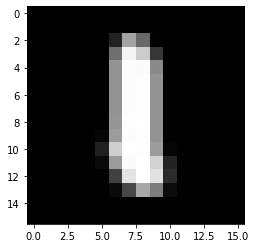

true label = y = 1.0

(x_min, x_max) = (-1.0, 0.961)


In [4]:
idx = np.random.choice(len(train_dataset))

x = train_dataset[idx][0]
print(f'x of {x.shape} :')
plt.imshow(x[0], cmap='gray')
plt.show()

print(f'true label = y = {train_dataset[idx][1]}\n')

print(f'(x_min, x_max) = {x.min().item(), round(x.max().item(),3)}')

# Define model (QNN), training and test loops

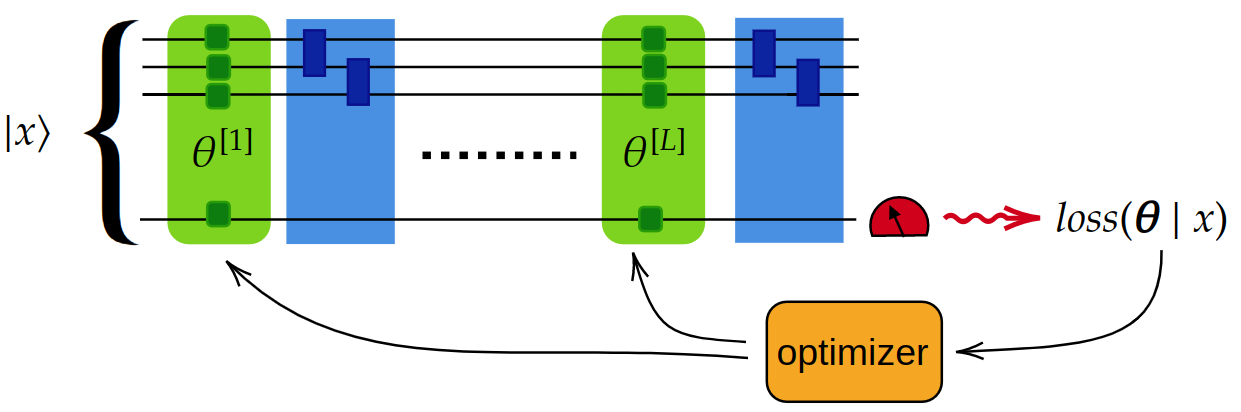

### QNN = parameterized quantum circuit (PQC)



A PQC is made of $L$ quantum layers. 
Here, each quantum layer $l$ has two parts: rotation $\text{R}_y(\theta^{[l]})$ in green and entangling $\text{CXs}$ in blue color.

-----------

__The rotation part__ is made of the tensor-product 
$\ \text{R}_y(\theta^{[l]}) = \displaystyle\bigotimes_{i} \text{R}_y(\theta^{[l]}_i)\ $
of single-qubit rotations (unitary gates) 
$\ \text{R}(\theta) = \cos(\theta) I + \texttt{i}\sin(\theta)\,Y$ around $y$-axis.
where $i\in\{1,\cdots,n\}$ is the qubit-index, the angles $\theta^{[l]}=(\theta^{[l]}_1,\cdots,\theta^{[l]}_n)$ of rotations are learnable parameters, and $n$ is the number of qubits.
$I$ is the Identity and $X, Y$ are the Pauli operators.
<br>


__The entangling part__ is made of the tensor-product 
$\text{CXs} = \displaystyle\bigotimes_{(i,j)} \text{CX}_{(i,j)}$
of two-qubit
$\text{CX}_{(i,j)} = |0\rangle_i\langle 0|\otimes I_j +|1\rangle_i\langle 1|\otimes X_j$ gates,
where $(i,j)$ represents the pair of control and target qubits $i$ and $j$, respectively.
This part will create entanglement between qubits and facilitate quantum information transfer between qubits. 
However, this part carries no learnable parameters.

-------------

__Input to the PQC__ is a $l_2$-normalized (quantum state) vector $|x\rangle$ of $2^n$ components. The ket $|x\rangle$ comes from the input vector $x$ after flattening a $\text{size}\times\text{size}$ image from the data.
Since $\text{size}\times\text{size}=:2^n=\text{dim}$ by definition and $\text{size}=16$, $n=8$.



__After the PQC__, we perform measurement on $|x,\Theta\rangle$ in the $z$-basis (computational-basis) and get a probability-vector $\textbf{p}(x,\Theta)=(p_0,\cdots,p_{\text{dim}})$. Then we get the marginal probability
$\sum_{i \text{ is even}} p_i$. This whole procedure is equivalent to performing a $z$-measurement on the last qubit shown in red color and calculating the probability for the 0 outcome. With the marginal probability, we compute $loss(\Theta|x)$. All the learnable parameters are made of $\Theta=\{\theta^{[1]}, \cdots, \theta^{[L]}\}$ associated with the quantum layer.



For details on the parameterized quantum circuit, see https://iopscience.iop.org/article/10.1088/2058-9565/ab4eb5
 


In [5]:

n = int(2*np.log2(size))
dim = 2**n              # dimension of the n-qubit Hilbert space


#--------------------------------------------------------------------------------------

'''0 outcome projector on the last qubit'''

last_qubit_proj = torch.tensor([(1 + (-1)**i)/2 for i in range(dim)], dtype=torch.float32)
last_qubit_proj


tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"    # Get gpu or cpu device for training
print(f"Using {device} device\n")

#=====================================================================================


class QNN(torch.nn.Module):                              # Define model
    def __init__(self, n, L):                            # number of qubits = n, number of quantum layers = L
        super().__init__()
        
        self.flatten = nn.Flatten()
        
        angles = torch.empty((L, n), dtype=torch.float64)
        torch.nn.init.uniform_(angles, -0.01, 0.01)
        self.angles = torch.nn.Parameter(angles)                   # it makes angles learnable parameters
       

    def forward(self, x):
        x = self.flatten(x)
        x /= torch.linalg.norm(x.clone(), ord=2, dim=1, keepdim=True)       # L2 normalization to change x --> |x⟩
        
        '''initializing parameterized quantum circuits (PQC)'''
        qc = quantum_circuit(num_qubits = n, state_vector = x.T)   # each column is a feature-vector of an example
        for l in range(L):
            qc.Ry_layer(self.angles[l].to(torch.cfloat))           # rotation part of lth quantum layer
            qc.cx_linear_layer()                                   # entangling part of lth quantum layer

        'after passing through the PQC, measurement on the output-ket in the computational basis'
        x = torch.real(qc.probabilities())               # each column is a probabilities-vector for an example 
                                                         # x.shape = (dim, batch size)
        
        #print(torch.sum(x, dim=0))                      # to see whether probabilities add up to 1 or not

        x = torch.matmul(x.T, last_qubit_proj)           # probability of getting 0 outcome on the last qubit
        return x  



Using cpu device



In [7]:

def performance_estimate(dataset, model, loss_fn, train_or_test):
    '''this function computes accuracy and loss of a model on the training or test set'''
    data_size = len(dataset)
    
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    num_batches = len(dataloader)
    
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            
            pred = torch.stack([1-pred, pred]).T
            accuracy += (pred.argmax(1) == y).sum().item()         
    accuracy /= data_size                                            # accuracy lies in the interval [0, 1]  
    loss /= num_batches
    print(f"{train_or_test} accuracy: {round(accuracy, 3)},  {train_or_test} loss: {round(loss,3)}")
    return accuracy, loss




def one_epoch(model, loss_fn, optimizer, dataset, batch_size):
    
    A_train, L_train, A_test, L_test = [], [], [], []

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        out = model(X)                             # Perform a single forward pass 
        loss = loss_fn(out, y)          
    
        optimizer.zero_grad()                      # Clear gradients
        loss.backward()                            # Derive gradients, backpropagation
        optimizer.step()                           # Update parameters based on gradients
        
    
        if batch % batch_size == 0: 
            #As training progress, computing and appending loss and accuracy of the model on train and test set
            accuracy_train, loss_train = performance_estimate(train_dataset, model, loss_fn, 'train')
            accuracy_test, loss_test = performance_estimate(test_dataset, model, loss_fn, 'test ')
            print()
            
            A_train.append(accuracy_train)        
            L_train.append(loss_train)
            A_test.append(accuracy_test)
            L_test.append(loss_test)
            
            #print(f"train loss: {round(loss,3)}")
    
    return A_train, L_train, A_test, L_test 




'''Binary Cross Entropy Loss'''    

def training(dataset, batch_size, n, L, lr_, weight_decay_, epochs):
    
    model = QNN(n=n, L=L).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_, weight_decay=weight_decay_)
    
    A_Train, L_Train, A_Test, L_Test = [], [], [], []
    for t in range(epochs): 
        print(f"Epoch {t+1} ---------------------------------- \n")
        #As training progress, computing and appending loss and accuracy of the model on train and test set
        A_train, L_train, A_test, L_test = one_epoch(model, loss_fn, optimizer, dataset, batch_size)
        A_Train += A_train
        L_Train += L_train 
        A_Test += A_test
        L_Test += L_test
        
        #accuracy, loss = performance_estimate(test_dataset, model, loss_fn, 'test ')
    
    model_state_dict = model.state_dict()           # for saving or loading the trained model
    
    return A_Train, L_Train, A_Test, L_Test, model_state_dict
    

# training...

In [8]:
%%time


L = 3

n_angs = n*L

print("number of qubits = ", n)
print("number of quantum layers = ", L)
print(f"number of angles (learnable parameters of quantum circuit) = {n_angs}\n ")

#--------------------------------------------------------------------------------------


batch_size = 64
print(f'batch_size = {batch_size}\n')


#----------------------------------------------------------------------------------


A_Train, L_Train, A_Test, L_Test, model_state_dict = training(train_dataset, batch_size=batch_size, n=n, L=L,
                                                              lr_=1e-3, weight_decay_=1e-8, epochs=3)


print(f' ~~~~~ training is done ~~~~~\n')

number of qubits =  8
number of quantum layers =  3
number of angles (learnable parameters of quantum circuit) = 24
 
batch_size = 64

Epoch 1 ---------------------------------- 

train accuracy: 0.629,  train loss: 0.681
test  accuracy: 0.652,  test  loss: 0.679

train accuracy: 0.826,  train loss: 0.652
test  accuracy: 0.841,  test  loss: 0.649

train accuracy: 0.82,  train loss: 0.622
test  accuracy: 0.833,  test  loss: 0.618

train accuracy: 0.861,  train loss: 0.582
test  accuracy: 0.864,  test  loss: 0.577

Epoch 2 ---------------------------------- 

train accuracy: 0.865,  train loss: 0.579
test  accuracy: 0.871,  test  loss: 0.574

train accuracy: 0.944,  train loss: 0.543
test  accuracy: 0.948,  test  loss: 0.538

train accuracy: 0.967,  train loss: 0.521
test  accuracy: 0.967,  test  loss: 0.515

train accuracy: 0.929,  train loss: 0.509
test  accuracy: 0.93,  test  loss: 0.505

Epoch 3 ---------------------------------- 

train accuracy: 0.928,  train loss: 0.508
test  accu

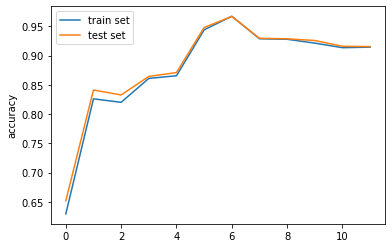

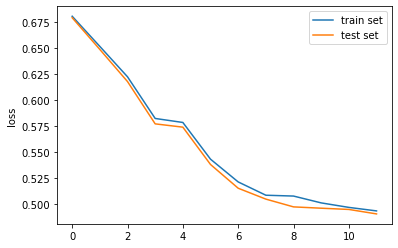

In [9]:
plt.plot(A_Train, label='train set')
plt.plot(A_Test, label='test set')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(L_Train, label='train set')
plt.plot(L_Test, label='test set')
plt.ylabel('loss')
plt.legend()
plt.show()

## save model

In [10]:
torch.save(model_state_dict, "model_MNIST_QNN2.pth")

## load model

In [11]:
model = QNN(n=n, L=L).to(device)
model.load_state_dict(model_state_dict)

#model.load_state_dict(torch.load("model_MNIST_QNN.pth"))

<All keys matched successfully>

## predict test examples

x of torch.Size([1, 16, 16]) :


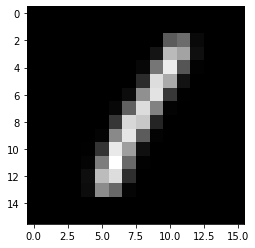

true label = y = 1.0

predicted label = 1



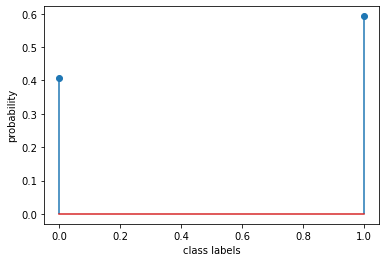

The sum of probability = 1.0


In [12]:
idx = np.random.choice(len(test_dataset))

x = test_dataset[idx][0]
print(f'x of {x.shape} :')
plt.imshow(x[0], cmap='gray')
plt.show()

print(f'true label = y = {test_dataset[idx][1]}\n')


out = model(x.view(1, 1, size, size)).detach().flatten()
prob = torch.stack([1 - out, out])
pred = prob.argmax().item()
print(f'predicted label = {pred}\n')

plt.stem(np.arange(2), prob)
plt.ylabel('probability')
plt.xlabel('class labels')
plt.show()

print(f'The sum of probability = {torch.sum(prob).item()}')

$ $

$ $

## simplified training loop

In [13]:
def one_epoch_(model, loss_fn, optimizer, dataset, batch_size):
    
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        out = model(X)                             # Perform a single forward pass
        loss = loss_fn(out, y)          
    
        optimizer.zero_grad()                      # Clear gradients
        loss.backward()                            # Derive gradients, backpropagation
        optimizer.step()                           # Update parameters based on gradients
    
        if batch % batch_size == 0: 
            print(f"train loss: {round(loss.item(),3)}")


    
    
def training_(dataset, batch_size, n, L, lr_, weight_decay_, epochs):
    
    model = QNN(n=n, L=L).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_, weight_decay=weight_decay_)
    
    for t in range(epochs): 
        print(f"Epoch {t+1} ---------------------------------- \n ")
        one_epoch_(model, loss_fn, optimizer, dataset, batch_size)
        
        #accuracy_train, loss_train = performance_estimate(train_dataset, model, loss_fn, 'train')
        #accuracy_test, loss_test = performance_estimate(test_dataset, model, loss_fn, 'test ')
        #print()

    
    model_state_dict = model.state_dict()
    return model_state_dict

    

In [14]:
%%time


batch_size = 64
print(f'batch_size = {batch_size}\n')

#----------------------------------------------------------------------------------

model_state_dict = training_(train_dataset, batch_size=batch_size, lr_=1e-3, n=n, L=L, 
                             weight_decay_=1e-8, epochs=3)

print()
print(f' ~~~~~ training is done ~~~~~\n')

batch_size = 64

Epoch 1 ---------------------------------- 
 
train loss: 0.674
train loss: 0.64
train loss: 0.594
train loss: 0.566
Epoch 2 ---------------------------------- 
 
train loss: 0.566
train loss: 0.575
train loss: 0.516
train loss: 0.5
Epoch 3 ---------------------------------- 
 
train loss: 0.52
train loss: 0.511
train loss: 0.488
train loss: 0.493

 ~~~~~ training is done ~~~~~

CPU times: user 1min 33s, sys: 47.8 ms, total: 1min 33s
Wall time: 23.3 s


In [15]:
%%time


model = QNN(n=n, L=L).to(device)
model.load_state_dict(model_state_dict)
loss_fn = nn.BCELoss()


accuracy_train, loss_train = performance_estimate(train_dataset, model, loss_fn, 'train')
accuracy_test, loss_test = performance_estimate(test_dataset, model, loss_fn, 'test ')
print()



train accuracy: 0.914,  train loss: 0.493
test  accuracy: 0.916,  test  loss: 0.492

CPU times: user 22.4 s, sys: 7.94 ms, total: 22.4 s
Wall time: 5.62 s


# 